In [8]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 12})

In [9]:
def foo_k_r(T):
    return k_r0 * math.e**(-E_a/(R_u*T))

In [10]:
def foo_k(T, gas_name):
    if gas_name == 'H2':
        a0 = 0.3975
        a1 = 0.4814/10**4
        a2 = -1.073/10**7
        a3 = 4.6863/10**11
        a4 = -8.5361/10**15
        a5 = 5.6934/10**19
    elif gas_name == 'O2':
        a0 = 0.4697
        a1 = -2.9819/10**4
        a2 = 2.0320/10**7
        a3 = -7.1938/10**11
        a4 = 12.311/10**15
        a5 = -8.0736/10**19
    elif gas_name == 'H2O':
        a0 = 0.3834
        a1 = -1.8579/10**4
        a2 = 0.6266/10**7
        a3 = -1.0528/10**11
        a4 = 0.93554/10**15
        a5 = -0.38512/10**19
    else:
        print('Houston we have a problem')
    return 1 + a0 + a1*T + a2*T**2 + a3*T**3 + a4*T**4 + a5*T**5

In [48]:
def foo_alpha(r):
    if abs(r) >= 0.0000001:
        a = 1 - math.e**(-r)
        return (1-a/r)/a
    else:
        return 0.5

In [93]:
# параметры установки
d = 45*10**(-3) # калибр
S = math.pi*d**2/4 # площадь
W_0 = 0.005 # объем каморы
l_d = 4.5 # длина ствола
m_elem = 0.52 # масса МЭ
p_f = 172 * 10**6 # давление форсирования

In [95]:
k_r0 = 9.87 * 10**8 # предэскп. множитель 
Q_t = 13.4 * 10**6 # энергия образования 1 кг продуктов реакций 
# E_ign = 0.5*10**6 # энергия воспламенителя
E_ign = 0*10**6 # энергия воспламенителя
E_a = 60*10**3 # энергия активации

In [96]:
v_p0 = 0 # начальная скорость
x_p0 = 0 # начальная координата
p_a = 10**5 # атмосфэрное давление

In [97]:
p_0 = 34.5 * 10**6 # начальное давление
T_0 = 300 # начальная температура
R_u = 8.31446262 # универсальная газовая постоянная
hi_O2_and_H2_0 = 1/8 # начальное соотношение мольных долей

In [98]:
mu_H2 = 2*10**(-3) # молярная масса водорода
mu_O2 = 16*10**(-3) # молярная масса кислорода
mu_H2O = 18*10**(-3) # молярная масса воды

In [99]:
def C_initial(p_0, W_0, T_0, hi_second_to_first):
    n_smesi = p_0 * W_0/(R_u * T_0)
    n_first_0 = n_smesi/(hi_second_to_first+1)
    n_second_0 =  n_first_0 * hi_second_to_first  
    n_result_0 = 0
    return np.array([n_first_0/W_0,
                    n_second_0/W_0,
                    0])

In [130]:
def termodynamic_system(p_0, W_0, T_0, hi_second_to_first):
    tau = 0 # время от начала процесса
    
    C_n_1 = C_initial(p_0, W_0, T_0, hi_second_to_first) # начальный вектор C

    C_n = C_n_1

    P_n = np.array([0,
                    0,
                    foo_k_r(T_0)*C_n_1[0]*C_n_1[1]**(1/2)]) # начальный вектор Р

    D_n = np.array([foo_k_r(T_0)*C_n_1[1]**(1/2), 
                    1/2*foo_k_r(T_0)*C_n_1[0]*C_n_1[1]**(-1/2),
                    0]) # начальный вектор D
    W_n_1 = W_0 # начальный объем
    v_p = v_p0 # начальная скорость
    x_p = x_p0 # начальная координата
    T = T_0 # начальная температура
    p_m = p_0 # начальное давление

    tau_arr = np.array([])
#     C_H2_arr = np.array([])
#     C_O2_arr = np.array([])
#     C_H2O_arr = np.array([])
#     m_H2_arr = np.array([])
#     m_O2_arr = np.array([])
#     m_H2O_arr = np.array([])
    v_p_arr = np.array([])
    p_m_arr = np.array([])
    x_p_arr = np.array([])
    T_arr = np.array([])

    dt = 1e-10

    schetchik = 0
    falg_fors = 0
    flag_dt = 0

    while x_p <= l_d: # условие цикла, пока МЭ не покинул дульный срез
        
        schetchik+=1
        
        if tau<=300_000*dt and flag_dt == 0:
            dt = 1e-9
        elif ((p_m_arr[-1] - p_m_arr[-2])/p_m_arr[-2] * 100) >= 2 and flag_dt == 0:
            dt = 1e-10
            flag_dt = 1
        elif ((p_m_arr[-1] - p_m_arr[-2])/p_m_arr[-2] * 100) >= 6 and flag_dt == 1:
            dt = 1e-12
            flag_dt = 2
        elif ((p_m_arr[-1] - p_m_arr[-2])/p_m_arr[-2] * 100) >= 10 and flag_dt == 2:
            dt = 1e-14
            flag_dt = 3
        elif ((p_m_arr[-1] - p_m_arr[-2])/p_m_arr[-2] * 100) <= 0 and flag_dt == 3:
            dt = 1e-9
            flag_dt = 4
        elif flag_dt == 4:
            dt = 5e-9

        tau += dt # время от начала процесса

        C_n = C_n_1 # вектор С

        W_n = W_n_1

        M_p = mu_H2O * C_n[2] * W_n

        n_H2 = C_n[0] * W_n # количество вещества водорода
        n_O2 = C_n[1] * W_n # количество вещества кислорода
        n_H2O = C_n[2] * W_n  # количество вещества воды

        m_H2 = n_H2 * mu_H2 # масса водорода
        m_O2 = n_O2 * mu_O2 # масса кислорода
        m_H2O = n_H2O * mu_H2O # масса воды

        n_smesi = n_H2 + n_O2 + n_H2O # количество вещества смеси

        phi = (1+(m_H2 + m_O2 + m_H2O)/(3*m_elem)) # фиктивность, масса всего

        # расчет показателя адиабаты смеси 
        help_value = (n_H2/(foo_k(T,'H2')-1) + n_O2/(foo_k(T,'O2')-1) + n_H2O/(foo_k(T,'H2O')-1))**(-1)
        k_smesi = 1 + n_H2*help_value + n_O2*help_value + n_H2O*help_value # показатель адиабаты смеси для формулы 4.5
        
        p_m = (k_smesi-1)/W_n * ((p_0*W_0)/(k_smesi_T_0-1) + Q_t*M_p - E_ign - phi/2*m_elem*v_p**2) # среднебаллистическое давление

        T = p_m*W_n/(R_u*n_smesi)

        if p_m <= p_f and falg_fors == 0:
            dv_p = 0
        elif p_m <= p_f and falg_fors == 1:
            dv_p = (p_m - p_a)*S/(phi*m_elem) * dt
        elif  p_m > p_f:
            falg_fors = 1
            dv_p = (p_m - p_a)*S/(phi*m_elem) * dt # диф. скорости МЭ

        v_p += dv_p # скорость МЭ

        dx_p = v_p * dt # диф. координаты МЭ

        x_p += dx_p  # координата МЭ

        W_n_1 = W_0 + x_p*S  # Заснарядный объем на n+1 шаге

        W_n = W_0 + (x_p-dx_p)*S # Заснарядный объем на n шаге

        # вектор P и D
        P_n = np.array([0, 
                        0, 
                        foo_k_r(T)*C_n[0]*C_n[1]**(1/2)])

        D_n = np.array([foo_k_r(T)*C_n[1]**(1/2), 
                        1/2*foo_k_r(T)*C_n[0]*C_n[1]**(-1/2),
                        0])


        foo_alpha_res = np.array([0,0,0]) # значение умножения алфа функции от произведения вектора D на dt, 
        for i in range(len(D_n)):
            foo_alpha_res[i] = foo_alpha(D_n[i]*dt)

        C_n_kr = W_n/W_n_1 * (C_n + (dt *(P_n-C_n*D_n))/(1+foo_alpha_res*D_n*dt)) # Предиктор вектора С

        if C_n_kr[1] >= 0 and C_n_kr[1] >= 0:
            D_n_kr = (np.array([foo_k_r(T)*C_n_kr[1]**(1/2), 
                                1/2*foo_k_r(T)*C_n_kr[0]*C_n_kr[1]**(-1/2),
                                0]) + D_n)/2 # Предиктор вектора D
        else:
            D_n_kr = np.array([0,0,0])

        foo_alpha_res = np.array([0,0,0]) # значение умножения алфа функции от произведения вектора D на dt, 
        for i in range(len(D_n_kr)):
            foo_alpha_res[i] = foo_alpha(D_n_kr[i]*dt)


        if C_n_kr[0] >= 0 and C_n_kr[1] >= 0:
            P_n_kr = foo_alpha_res*np.array([0, 
                                             0, 
                                             foo_k_r(T)*C_n_kr[0]*C_n_kr[1]**(1/2)]) + (1-foo_alpha_res)*P_n # Предиктор вектора P    
        else:
            P_n_kr = np.array([0,0,0])

        C_n_1 = W_n/W_n_1 * (C_n + (dt *(P_n_kr-C_n*D_n_kr))/(1+foo_alpha_res*D_n_kr*dt)) # Корректор вектора С

        if schetchik % 10_000 == 0:
            tau_arr = np.append(tau_arr, tau)
            x_p_arr = np.append(x_p_arr, x_p)
#             C_H2_arr = np.append(C_H2_arr, C_n[0])
#             C_O2_arr = np.append(C_O2_arr, C_n[1])
#             C_H2O_arr = np.append(C_H2O_arr, C_n[2])
#             m_H2_arr = np.append(m_H2_arr, m_H2)
#             m_O2_arr = np.append(m_O2_arr, m_O2)
#             m_H2O_arr = np.append(m_H2O_arr, m_H2O)
            v_p_arr = np.append(v_p_arr, v_p)
            T_arr = np.append(T_arr, T)
            p_m_arr = np.append(p_m_arr, p_m)

    return {'tau':tau_arr, 'x_p':x_p_arr,
           'v_p':v_p_arr, 'T':T_arr, 'p_m':p_m_arr}

#     return {'tau_arr':tau_arr, 'x_p_arr':x_p_arr, 
#             'C_H2_arr':C_H2_arr, 'C_O2_arr':C_O2_arr, 'C_H2O_arr':C_H2O_arr,
#            'm_H2_arr':m_H2_arr, 'm_O2_arr':m_O2_arr, 'm_H2O_arr':m_H2O_arr,
#            'v_p_arr':v_p_arr, 'T_arr':T_arr, 'p_m_arr':p_m_arr}

In [132]:
res = termodynamic_system(p_0, W_0, T_0, hi_O2_and_H2_0)

In [133]:
df = pd.DataFrame.from_dict(res)

In [134]:
df.head()

,tau,x_p,v_p,T,p_m
0,0.00001,0.0,0.0,300.142760,3.451620e+07
1,0.00002,0.0,0.0,300.287176,3.453260e+07
2,0.00003,0.0,0.0,300.433271,3.454918e+07
3,0.00004,0.0,0.0,300.581082,3.456595e+07
4,0.00005,0.0,0.0,300.730648,3.458293e+07


In [135]:
df.p_m.max()/10**6, df.loc[df.shape[0]-1].v_p

(221.7132726283405, 1664.2513686207114)

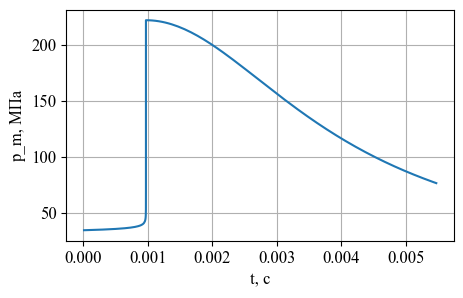

In [136]:
plt.figure(figsize=(5,3))
plt.plot(df.tau, df.p_m/10**6)
plt.xlabel('t, с')
plt.ylabel('p_m, МПа')
plt.grid()

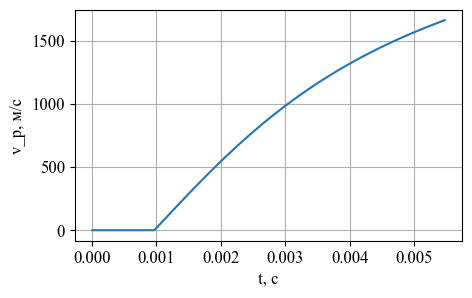

In [137]:
plt.figure(figsize=(5,3))
plt.plot(df.tau, df.v_p)
plt.xlabel('t, с')
plt.ylabel('v_p, м/с')
plt.grid()

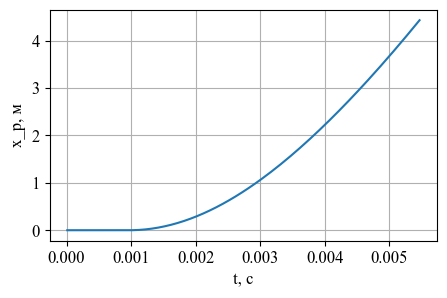

In [138]:
plt.figure(figsize=(5,3))
plt.plot(df.tau, df.x_p)
plt.xlabel('t, с')
plt.ylabel('x_p, м')
plt.grid()